# Failure probability calculations with a fragility curve

In this example, we will demonstrate how to calculate the failure probability of a levee using a fragility curve.

Fragility curve is a function that describes the relation between the load imposed on the levee and the corresponding  (conditional) failure probability. Typically a fragility curve is expressed by the following relation: $h \rightarrow P(Z<0|h)$. By integrating the fragility curve with the load statistics, the failure probability can be estimated. The goal is to derive the following probability: 

$P(Z<0) = \int P(Z<0 | h)\cdot f(h) dh$

First, let's import the necessary packages:

In [1]:
from ptk import *
from scipy import interpolate
import matplotlib.pyplot as plt

We consider a simple fragility curve, $h \rightarrow P(Z<0|h)$:

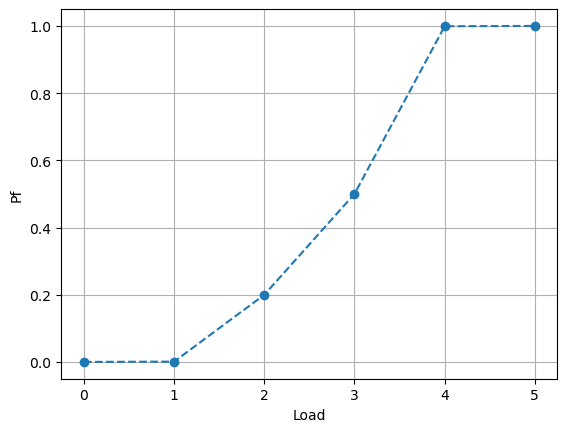

In [2]:
fc = {"h": [0,1,2,3,4,5], "Pf": [0.0001,0.001,0.2,0.5,0.999,0.99999]}

plt.plot(fc["h"], fc["Pf"], 'o--')
plt.xlabel("Load")
plt.ylabel("Pf")
plt.grid()

The limit state function is expressed as:

$Z = \beta(h) + U$

where:
* $\beta(h)$ is the reliability index, which is determined from the fragility curve corresponing to a given load $h$.
* $U$ is a standard normal random variable.

In [3]:
def limit_state_function(h, U):

    fc = {"h": [0,1,2,3,4,5], "Pf": [0.0001,0.001,0.2,0.5,0.999,0.99999]}
    reliability_index = [-StandardNormal.get_u_from_p(fc["Pf"][i]) for i in range(0, len(fc["Pf"]))]

    f = interpolate.interp1d(fc["h"], reliability_index, fill_value=('extrapolate'))
    
    return f(h) + U

To perform a reliability analysis, we create a reliability project and specify the limit state function (model):

In [4]:
project = ReliabilityProject()
project.model = limit_state_function

Next, we define the random variables $h$ and $U$. In this example, the load $h$ follows a log-normal distribution with a mean of $1.5$ and a standard deviation of $0.1$.

In [5]:
project.variables["h"].distribution = "log_normal"
project.variables["h"].mean = 1.5
project.variables["h"].deviation = 0.1

project.variables["U"].distribution = "normal"
project.variables["U"].mean = 0.0
project.variables["U"].deviation = 1.0

We calculate $P(Z<0)$ with methods `form` and `numerical_integration`.

In [8]:
project.settings.reliability_method = "form"
project.settings.relaxation_factor = 0.75
project.settings.maximum_iterations = 50
project.settings.variation_coefficient = 0.02

project.run()
print(f"P(Z<0) {project.settings.reliability_method} = {project.design_point.probability_failure}")

project.settings.reliability_method = "numerical_integration"
project.settings.stochast_settings["h"].intervals = 50
project.settings.stochast_settings["U"].intervals = 50

project.run()
print(f"P(Z<0) {project.settings.reliability_method} = {project.design_point.probability_failure}")

P(Z<0) form = 0.027159072738005066
P(Z<0) numerical_integration = 0.028540261263899226
